In [1]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install -U sentence-transformers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sentence_transformers import SentenceTransformer, util
import os

import nltk
import re
import string
from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
import collections
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1. [quran dataset](https://www.kaggle.com/datasets/alizahidraja/quran-english)
2. [bible dataset](https://www.kaggle.com/datasets/phyred23/bibleverses)

In [2]:
en_quran = pd.read_csv('../input/quran-english/Quran_English.csv')
en_quran.head(1)

,Name,Surah,Ayat,Verse
0,The Opening,1,1,"In the name of Allah, the Beneficent, the Merc..."


In [3]:
kjv = pd.read_csv('/kaggle/input/bibleverses/bible_data_set.csv')
kjv.book.unique()

array(['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy',
       'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings',
       '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
       'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
       'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel',
       'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah',
       'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi',
       'Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans',
       '1 Corinthians', '2 Corinthians', 'Galatians', 'Ephesians',
       'Philippians', 'Colossians', '1 Thessalonians', '2 Thessalonians',
       '1 Timothy', '2 Timothy', 'Titus', 'Philemon', 'Hebrews', 'James',
       '1 Peter', '2 Peter', '1 John', '2 John', '3 John', 'Jude',
       'Revelation'], dtype=object)

In [4]:
old = ['Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy',
       'Joshua', 'Judges', 'Ruth', '1 Samuel', '2 Samuel', '1 Kings',
       '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
       'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes',
       'Song of Solomon', 'Isaiah', 'Jeremiah', 'Lamentations', 'Ezekiel',
       'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah', 'Micah',
       'Nahum','Habakkuk','Zephaniah','Haggai','Zechariah','Malachi']

len(old) 


39

In [5]:
old_kjv = kjv[kjv.book.isin(old)]

en_torah = old_kjv.copy()

In [6]:
len(kjv) - len(old_kjv)


7957

In [7]:
en_torah.head(1)

,citation,book,chapter,verse,text
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...


In [8]:
max_len = en_quran.Verse.str.split().map(lambda x: len(x))
max_len = max_len.tolist()
max_val =  max(max_len)
print(max_val)
max_idx = max_len.index(max_val)
max_idx

273


288

In [9]:
en_torah.text[10]

'And God said, Let the earth bring forth grass, the herb yielding seed, and the fruit tree yielding fruit after his kind, whose seed is in itself, upon the earth: and it was so. \n'

In [10]:
max_len = en_torah.text.str.split().map(lambda x: len(x))
max_len = max_len.tolist()
max_val =  max(max_len)
print(max_val)
max_idx = max_len.index(max_val)
max_idx

86


12826

In [11]:
def wordLemmatizer(data):
    tag_map = collections.defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    clean_k =pd.DataFrame()
    word_Lemmatized = WordNetLemmatizer()
    for index,entry in tqdm(enumerate(data)):
        
        Final_words = []
        for word, tag in pos_tag(entry):
            if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        
        clean_k.loc[index,'Keyword_final'] = str(Final_words)
    clean_k=clean_k.replace(to_replace ="'", value = '', regex = True)
    clean_k=clean_k.replace(to_replace =" ", value = '', regex = True)
    clean_k=clean_k.replace(to_replace ="\[", value = '', regex = True)
    clean_k=clean_k.replace(to_replace ='\]', value = '', regex = True)
    return clean_k



In [12]:
%%time
#from -> https://github.com/alizahidraja/QURAN-NLP/blob/master/Quran%2C%20Tafseer%20%26%20NLP.ipynb

en_torah['useful_info'] = en_torah.text.astype(str) 
en_torah["useful_info"] = en_torah.useful_info.replace(to_replace='[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]',value=' ',regex=True) 
#remove punctuation
en_torah.useful_info =en_torah.useful_info.replace(to_replace='-',value=' ',regex=True)
en_torah.useful_info =en_torah.useful_info.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
en_torah.useful_info =en_torah.useful_info.replace(to_replace='  ',value='',regex=True)   #remove double white space  
en_torah.useful_info =en_torah.useful_info.replace(to_replace="'",value='',regex=True)   


en_torah.useful_info = en_torah.useful_info.apply(lambda x:x.strip().lower())  # Ltrim and Rtrim of whitespace
en_torah["info_tokenize"]= [word_tokenize(entry) for entry in tqdm(en_torah["useful_info"])] 


en_torah["Keyword_final"] = wordLemmatizer(en_torah['info_tokenize'])
en_torah.head()

100%|██████████| 23145/23145 [00:04<00:00, 5443.94it/s]
23145it [02:08, 179.92it/s]


CPU times: user 2min 3s, sys: 11.3 s, total: 2min 14s
Wall time: 2min 15s


,citation,book,chapter,verse,text,useful_info,info_tokenize,Keyword_final
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...,in the beginning god created the heaven and th...,"[in, the, beginning, god, created, the, heaven...","beginning,god,create,heaven,earth"
1,Genesis 1:2,Genesis,1,2,"And the earth was without form, and void; and ...",and the earth was without form and void and da...,"[and, the, earth, was, without, form, and, voi...","earth,without,form,void,darkness,upon,face,dee..."
2,Genesis 1:3,Genesis,1,3,"And God said, Let there be light: and there wa...",and god said let there be light and there was ...,"[and, god, said, let, there, be, light, and, t...","god,say,let,light,light"
3,Genesis 1:4,Genesis,1,4,"And God saw the light, that it was good: and G...",and god saw the light that it was good and god...,"[and, god, saw, the, light, that, it, was, goo...","god,saw,light,good,god,divide,light,darkness"
4,Genesis 1:5,Genesis,1,5,"And God called the light Day, and the darkness...",and god called the light day and the darkness ...,"[and, god, called, the, light, day, and, the, ...","god,call,light,day,darkness,call,night,evening..."


In [13]:
%%time

en_quran['useful_info'] = en_quran.Verse.astype(str) 
en_quran["useful_info"] = en_quran.useful_info.replace(to_replace='[!"#$%&\'()*+,/:;<=>?@[\\]^_`{|}~]',value=' ',regex=True) 
#remove punctuation
en_quran.useful_info =en_quran.useful_info.replace(to_replace='-',value=' ',regex=True)
en_quran.useful_info =en_quran.useful_info.replace(to_replace='\s+',value=' ',regex=True)    #remove new line
en_quran.useful_info =en_quran.useful_info.replace(to_replace='  ',value='',regex=True)   #remove double white space  
en_quran.useful_info =en_quran.useful_info.replace(to_replace="'",value='',regex=True)   


en_quran.useful_info = en_quran.useful_info.apply(lambda x:x.strip().lower())  # Ltrim and Rtrim of whitespace
en_quran["info_tokenize"]= [word_tokenize(entry) for entry in tqdm(en_quran["useful_info"])] 


en_quran["Keyword_final"] = wordLemmatizer(en_quran['info_tokenize'])
en_quran.head()

100%|██████████| 6236/6236 [00:01<00:00, 5462.60it/s]
6236it [00:30, 202.97it/s]


CPU times: user 29.1 s, sys: 2.87 s, total: 32 s
Wall time: 32 s


,Name,Surah,Ayat,Verse,useful_info,info_tokenize,Keyword_final
0,The Opening,1,1,"In the name of Allah, the Beneficent, the Merc...",in the name of allah the beneficent the merciful.,"[in, the, name, of, allah, the, beneficent, th...","name,allah,beneficent,merciful"
1,The Opening,1,2,"Praise be to Allah, Lord of the Worlds,",praise be to allah lord of the worlds,"[praise, be, to, allah, lord, of, the, worlds]","praise,allah,lord,world"
2,The Opening,1,3,"The Beneficent, the Merciful.",the beneficent the merciful.,"[the, beneficent, the, merciful, .]","beneficent,merciful"
3,The Opening,1,4,"Owner of the Day of Judgment,",owner of the day of judgment,"[owner, of, the, day, of, judgment]","owner,day,judgment"
4,The Opening,1,5,Thee (alone) we worship; Thee (alone) we ask f...,thee alone we worship thee alone we ask for help,"[thee, alone, we, worship, thee, alone, we, as...","thee,alone,worship,thee,alone,ask,help"


In [14]:
torah_list = en_torah.Keyword_final.tolist()
quran_list = en_quran.Keyword_final.tolist()
len(torah_list),len(quran_list)

(23145, 6236)

In [15]:
drop_columns = ['useful_info','info_tokenize','Keyword_final']
en_torah = en_torah.drop(drop_columns, axis=1)

In [16]:
en_quran = en_quran.drop(drop_columns, axis=1)


In [17]:
#asymmetric semantic search
model = SentenceTransformer('all-MiniLM-L12-v2', device="cuda")


#Compute embedding for both lists (quran and torah)
torah_embeddings = model.encode(torah_list, convert_to_tensor=True)
quran_embeddings = model.encode(quran_list, convert_to_tensor=True)

torah_embeddings = torah_embeddings.to('cuda')
torah_embeddings = util.normalize_embeddings(torah_embeddings)

quran_embeddings = quran_embeddings.to('cuda')
quran_embeddings = util.normalize_embeddings(quran_embeddings)


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/724 [00:00<?, ?it/s]

Batches:   0%|          | 0/195 [00:00<?, ?it/s]

In [18]:
len(torah_embeddings),len(quran_embeddings)

(23145, 6236)

In [19]:
%%time

hits = util.semantic_search(torah_embeddings, quran_embeddings, score_function=util.dot_score)

dot_score = util.dot_score(torah_embeddings[0], quran_embeddings[0]).item()

dot_score


CPU times: user 224 ms, sys: 38 ms, total: 262 ms
Wall time: 268 ms


0.4264531135559082

In [20]:
sim_quran_torah = en_torah.copy()
sim_quran_torah = sim_quran_torah.rename(columns={"citation": "t_citation", "book": "t_book", "chapter": "t_chapter", "verse": "t_verse", "text": "t_text"})


sim_quran_torah['q_Name'] = "Quran Surah Name"
sim_quran_torah['q_Surah'] = "Quran Surah Number"
sim_quran_torah['q_Ayat'] = "Quran Ayat Number of corresponding Surah"
sim_quran_torah['q_Verse'] = "Quranic Verse of Corresponding surah and ayat"

sim_quran_torah['similarity_score'] = 0.0

sim_quran_torah.head(1)

,t_citation,t_book,t_chapter,t_verse,t_text,q_Name,q_Surah,q_Ayat,q_Verse,similarity_score
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...,Quran Surah Name,Quran Surah Number,Quran Ayat Number of corresponding Surah,Quranic Verse of Corresponding surah and ayat,0.0


In [21]:
%%time

for i in range(len(torah_embeddings)):
    best_score = 0.0
    idx = 0
    for j in range(len(quran_embeddings)):
        dot_score = util.dot_score(torah_embeddings[i], quran_embeddings[j]).item()
        if(dot_score>best_score):
            best_score = dot_score
            idx = j
            
 
    sim_quran_torah.loc[i, 'similarity_score'] = best_score
    sim_quran_torah.loc[i, 'q_Name'] = en_quran.loc[idx, 'Name']
    sim_quran_torah.loc[i, 'q_Surah'] = en_quran.loc[idx, 'Surah']
    sim_quran_torah.loc[i, 'q_Ayat'] = en_quran.loc[idx, 'Ayat']
    sim_quran_torah.loc[i, 'q_Verse'] = en_quran.loc[idx, 'Verse']
    
sim_quran_torah.head()

CPU times: user 1h 33min 36s, sys: 5.38 s, total: 1h 33min 42s
Wall time: 1h 34min 1s


,t_citation,t_book,t_chapter,t_verse,t_text,q_Name,q_Surah,q_Ayat,q_Verse,similarity_score
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...,Tâ Hâ,20,4,A revelation from Him Who created the earth an...,0.815918
1,Genesis 1:2,Genesis,1,2,"And the earth was without form, and void; and ...",Cattle,6,79,Lo! I have turned my face toward Him Who creat...,0.765902
2,Genesis 1:3,Genesis,1,3,"And God said, Let there be light: and there wa...",The Story,28,71,"Say: Have ye thought, if Allah made night ever...",0.674126
3,Genesis 1:4,Genesis,1,4,"And God saw the light, that it was good: and G...",The Troops,39,69,And the earth shineth with the light of her Lo...,0.714607
4,Genesis 1:5,Genesis,1,5,"And God called the light Day, and the darkness...",Noah,71,5,He said: My Lord! Lo! I have called unto my pe...,0.761022


In [22]:

sim_quran_torah.sort_values(by=['similarity_score'], ascending=False)

,t_citation,t_book,t_chapter,t_verse,t_text,q_Name,q_Surah,q_Ayat,q_Verse,similarity_score
1691,Exodus 7:6,Exodus,7,6,And Moses and Aaron did as the LORD commanded ...,The Poets,26,48,The Lord of Moses and Aaron.,0.896903
1569,Exodus 2:15,Exodus,2,15,"Now when Pharaoh heard this thing, he sought t...",The Believer,40,26,"And Pharaoh said: Suffer me to kill Moses, and...",0.888560
14012,Psalms 7:17,Psalms,7,17,I will praise the LORD according to his righte...,The Most High,87,1,"Praise the name of thy Lord the Most High,",0.887202
2449,Exodus 32:11,Exodus,32,11,"And Moses besought the LORD his God, and said,...",Jonah,10,88,And Moses said: Our Lord! Lo! Thou hast given ...,0.883705
1260,Genesis 42:8,Genesis,42,8,"And Joseph knew his brethren, but they knew no...",Joseph,12,58,And Joseph’s brethren came and presented thems...,0.883682
...,...,...,...,...,...,...,...,...,...,...
12292,Ezra 10:40,Ezra,10,40,"Machnadebai, Shashai, Sharai, \n",The Prophets,21,85,"And (mention) Ishmael, and Idris, and Dhu’l-Ki...",0.326191
12291,Ezra 10:39,Ezra,10,39,"And Shelemiah, and Nathan, and Adaiah, \n",The Poets,26,48,The Lord of Moses and Aaron.,0.325005
6395,Joshua 21:14,Joshua,21,14,"And Jattir with her suburbs, and Eshtemoa with...",The Poets,26,208,And We destroyed no township but it had its wa...,0.324395
12555,Nehemiah 10:6,Nehemiah,10,6,"Daniel, Ginnethon, Baruch, \n",Sâd,38,50,"Gardens of Eden, whereof the gates are opened ...",0.309046


In [23]:
sim_quran_torah = sim_quran_torah.sort_values(by=['similarity_score'], ascending=False)

In [24]:
sim_quran_torah.to_csv("all-MiniLM-L12-v2_similarities_between_quran_and_torah.csv",index = False)

<AxesSubplot:>

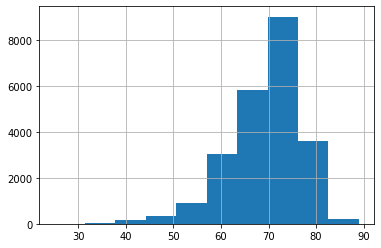

In [25]:
sim_quran_torah['similarity_score'] =sim_quran_torah['similarity_score'] * 100
sim_quran_torah['similarity_score'] =sim_quran_torah['similarity_score'].astype(int)
sim_quran_torah['similarity_score'].hist()